# CNN untuk Klasifikasi Sampah Otomatis

**Tugas:** Membangun model CNN dari awal untuk klasifikasi 5 jenis sampah (foodwaste, glass, metal, paper, plastic) untuk sistem pemisah sampah otomatis.

**Konfigurasi:** Menggunakan setting ringan untuk laptop dengan spesifikasi rendah.

In [6]:
# Import libraries yang diperlukan untuk CNN, image processing, dan evaluasi model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import os
import cv2
import pickle
from pathlib import Path
import pandas as pd

# Setup path untuk dataset, model, dan report
BASE_DIR = Path('.')
DATASET_DIR = BASE_DIR / 'datasets'
MODEL_DIR = BASE_DIR / 'models'
REPORT_DIR = BASE_DIR / 'report'

# Pastikan folder model dan report ada
MODEL_DIR.mkdir(exist_ok=True)
REPORT_DIR.mkdir(exist_ok=True)

# Konfigurasi untuk laptop dengan spec rendah
IMG_SIZE = 64  # Ukuran gambar kecil untuk mengurangi memory usage
BATCH_SIZE = 16  # Batch size kecil
EPOCHS = 10  # Epoch terbatas untuk training cepat
VALIDATION_SPLIT = 0.2

# Class names untuk klasifikasi sampah
CLASS_NAMES = ['foodwaste', 'glass', 'metal', 'paper', 'plastic']
NUM_CLASSES = len(CLASS_NAMES)

print(f"TensorFlow version: {tf.__version__}")
print(f"Dataset directory: {DATASET_DIR}")
print(f"Class names: {CLASS_NAMES}")
print(f"Configuration - Image size: {IMG_SIZE}x{IMG_SIZE}, Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}")

TensorFlow version: 2.13.0
Dataset directory: datasets
Class names: ['foodwaste', 'glass', 'metal', 'paper', 'plastic']
Configuration - Image size: 64x64, Batch size: 16, Epochs: 10


In [ ]:
# Load dan preprocessing dataset dari folder train, valid, test
# Normalisasi pixel values ke range 0-1 dan resize gambar ke ukuran kecil

def load_dataset(data_dir, img_size=IMG_SIZE):
    """Load gambar dari folder dan lakukan preprocessing"""
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(CLASS_NAMES):
        class_path = data_dir / class_name
        if class_path.exists():
            print(f"Loading {class_name} images from {class_path}")
            for img_file in class_path.glob('*.jpg'):
                try:
                    # Load dan resize gambar
                    img = cv2.imread(str(img_file))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_size, img_size))
                    
                    # Normalisasi pixel values ke 0-1
                    img = img.astype(np.float32) / 255.0
                    
                    images.append(img)
                    labels.append(class_idx)
                except Exception as e:
                    print(f"Error loading {img_file}: {e}")
    
    return np.array(images), np.array(labels)

# Load training, validation, dan test data
print("Loading training data...")
X_train, y_train = load_dataset(DATASET_DIR / 'train')

print("Loading validation data...")
X_val, y_val = load_dataset(DATASET_DIR / 'valid')

print("Loading test data...")
X_test, y_test = load_dataset(DATASET_DIR / 'test')

# Print informasi dataset
print(f"\nDataset Information:")
print(f"Training set: {X_train.shape} images, {len(np.unique(y_train))} classes")
print(f"Validation set: {X_val.shape} images, {len(np.unique(y_val))} classes")
print(f"Test set: {X_test.shape} images, {len(np.unique(y_test))} classes")
print(f"Image shape: {X_train[0].shape}")
print(f"Pixel value range: {X_train.min():.2f} - {X_train.max():.2f}")

# Visualisasi sample gambar dari setiap kelas
plt.figure(figsize=(15, 3))
for i, class_name in enumerate(CLASS_NAMES):
    # Ambil sample pertama dari setiap kelas
    class_indices = np.where(y_train == i)[0]
    if len(class_indices) > 0:
        sample_img = X_train[class_indices[0]]
        plt.subplot(1, 5, i+1)
        plt.imshow(sample_img)
        plt.title(f"{class_name}\n({len(class_indices)} images)")
        plt.axis('off')
plt.tight_layout()
plt.show()

Found 6722 images belonging to 5 classes.
Found 1678 images belonging to 5 classes.
Found 1678 images belonging to 5 classes.
Found 237 images belonging to 5 classes.
Found 237 images belonging to 5 classes.
Dataset Information:
Training set: 6722 images
Validation set: 1678 images
Test set: 237 images
Number of classes: 5
Class names: ['foodwaste', 'glass', 'metal', 'paper', 'plastic']
Dataset Information:
Training set: 6722 images
Validation set: 1678 images
Test set: 237 images
Number of classes: 5
Class names: ['foodwaste', 'glass', 'metal', 'paper', 'plastic']


In [3]:
# Desain arsitektur CNN sederhana dari awal dengan konfigurasi ringan
# Model terdiri dari Conv2D, MaxPooling2D, Flatten, dan Dense layers

def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Membuat model CNN sederhana"""
    
    model = keras.Sequential([
        # Layer input
        keras.Input(shape=input_shape),
        
        # Convolutional Layer 1 - filter sedikit untuk mengurangi computational load
        layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Convolutional Layer 2
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Convolutional Layer 3
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer untuk mengubah 2D ke 1D
        layers.Flatten(),
        
        # Dense layers dengan ukuran kecil
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),  # Dropout untuk mencegah overfitting
        
        # Output layer dengan softmax untuk klasifikasi multi-class
        layers.Dense(num_classes, activation='softmax')
    ], name='WasteClassificationCNN')
    
    return model

# Buat model CNN
model = create_cnn_model()

# Compile model dengan optimizer Adam dan loss function untuk multi-class classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Learning rate standar
    loss='sparse_categorical_crossentropy',  # Untuk integer labels
    metrics=['accuracy']
)

# Tampilkan arsitektur model
model.summary()

# Visualisasi arsitektur model
keras.utils.plot_model(
    model, 
    to_file=str(REPORT_DIR / 'model_architecture.png'),
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

print(f"\nModel created with {model.count_params():,} total parameters")
print("Model architecture saved to report/model_architecture.png")

Model: "WasteClassificationCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                         

Starting model training...
Configuration: 10 epochs, batch size 16
Epoch 1/10
Epoch 1/10
525/525 [==============================] - 46s 81ms/step - loss: 1.3790 - accuracy: 0.4043 - val_loss: 1.2629 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 2/10
525/525 [==============================] - 46s 81ms/step - loss: 1.3790 - accuracy: 0.4043 - val_loss: 1.2629 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 2/10
525/525 [==============================] - 46s 87ms/step - loss: 1.2298 - accuracy: 0.5031 - val_loss: 1.1306 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 3/10
525/525 [==============================] - 46s 87ms/step - loss: 1.2298 - accuracy: 0.5031 - val_loss: 1.1306 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 3/10
525/525 [==============================] - 46s 88ms/step - loss: 1.1285 - accuracy: 0.5464 - val_loss: 1.1090 - val_accuracy: 0.5736 - lr: 0.0010
Epoch 4/10
525/525 [==============================] - 46s 88ms/step - loss: 1.1285 - accuracy: 0.5464 - val_loss: 1.1090 - val_accuracy: 

Starting model training...
Configuration: 10 epochs, batch size 16
Epoch 1/10
Epoch 1/10
525/525 [==============================] - 46s 81ms/step - loss: 1.3790 - accuracy: 0.4043 - val_loss: 1.2629 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 2/10
525/525 [==============================] - 46s 81ms/step - loss: 1.3790 - accuracy: 0.4043 - val_loss: 1.2629 - val_accuracy: 0.4989 - lr: 0.0010
Epoch 2/10
525/525 [==============================] - 46s 87ms/step - loss: 1.2298 - accuracy: 0.5031 - val_loss: 1.1306 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 3/10
525/525 [==============================] - 46s 87ms/step - loss: 1.2298 - accuracy: 0.5031 - val_loss: 1.1306 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 3/10
525/525 [==============================] - 46s 88ms/step - loss: 1.1285 - accuracy: 0.5464 - val_loss: 1.1090 - val_accuracy: 0.5736 - lr: 0.0010
Epoch 4/10
525/525 [==============================] - 46s 88ms/step - loss: 1.1285 - accuracy: 0.5464 - val_loss: 1.1090 - val_accuracy: 

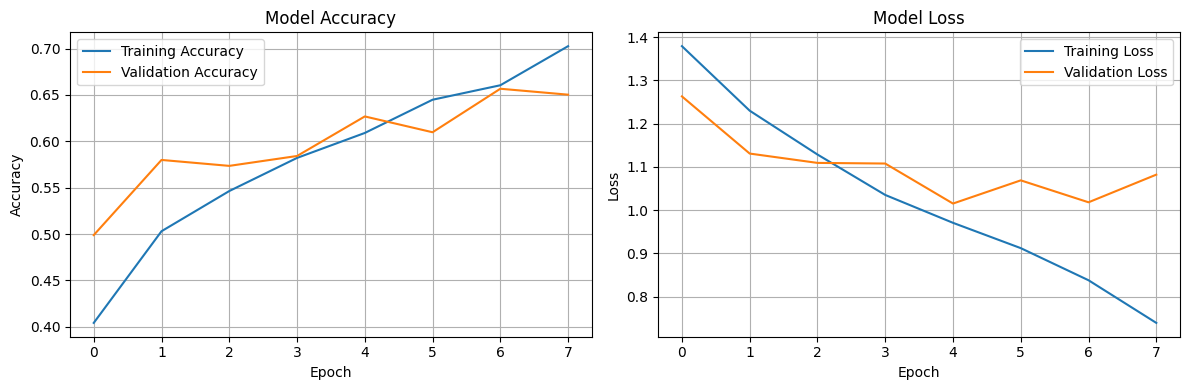

Training curves saved to report/training_curves.png


In [4]:
# Training model dengan konfigurasi ringan dan callback untuk monitoring
# Simpan history training untuk analisis overfitting

# Setup callback untuk monitoring training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

print("Starting model training...")
print(f"Configuration: {EPOCHS} epochs, batch size {BATCH_SIZE}")

# Training model
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

# Plot training history curves
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(str(REPORT_DIR / 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Simpan training history
with open(MODEL_DIR / 'training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training curves saved to report/training_curves.png")

Evaluating model on test set...
15/15 [==============================] - 1s 19ms/step

Test Set Performance:
Test Set Performance:
Accuracy: 0.6160
Precision: 0.5898
Recall: 0.6160
F1-Score: 0.5807

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.85      0.81      0.83        27
       glass       0.33      0.03      0.06        33
       metal       0.55      0.70      0.61        50
       paper       0.55      0.72      0.63        57
     plastic       0.67      0.67      0.67        70

    accuracy                           0.62       237
   macro avg       0.59      0.59      0.56       237
weighted avg       0.59      0.62      0.58       237


Accuracy: 0.6160
Precision: 0.5898
Recall: 0.6160
F1-Score: 0.5807

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.85      0.81      0.83        27
       glass       0.33      0.03      0.06        33
       metal    

Evaluating model on test set...
15/15 [==============================] - 1s 19ms/step

Test Set Performance:
Test Set Performance:
Accuracy: 0.6160
Precision: 0.5898
Recall: 0.6160
F1-Score: 0.5807

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.85      0.81      0.83        27
       glass       0.33      0.03      0.06        33
       metal       0.55      0.70      0.61        50
       paper       0.55      0.72      0.63        57
     plastic       0.67      0.67      0.67        70

    accuracy                           0.62       237
   macro avg       0.59      0.59      0.56       237
weighted avg       0.59      0.62      0.58       237


Accuracy: 0.6160
Precision: 0.5898
Recall: 0.6160
F1-Score: 0.5807

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.85      0.81      0.83        27
       glass       0.33      0.03      0.06        33
       metal    

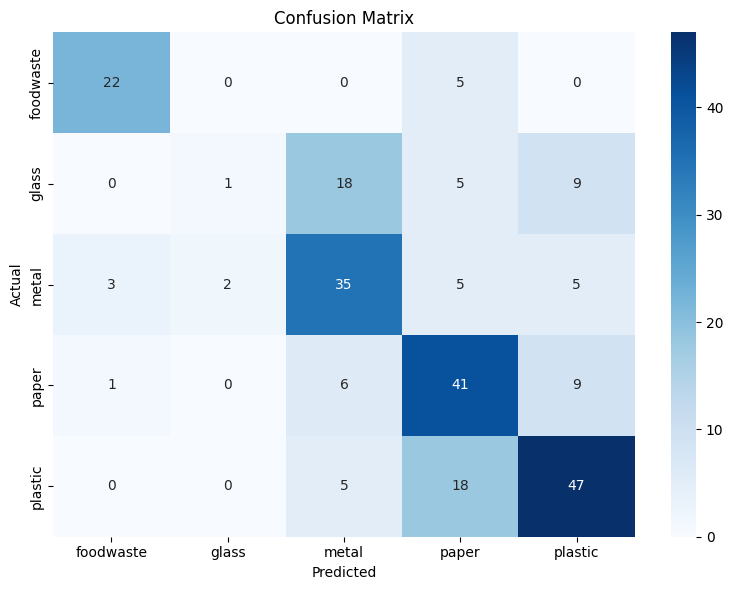

Evaluating model on test set...
15/15 [==============================] - 1s 19ms/step

Test Set Performance:
Test Set Performance:
Accuracy: 0.6160
Precision: 0.5898
Recall: 0.6160
F1-Score: 0.5807

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.85      0.81      0.83        27
       glass       0.33      0.03      0.06        33
       metal       0.55      0.70      0.61        50
       paper       0.55      0.72      0.63        57
     plastic       0.67      0.67      0.67        70

    accuracy                           0.62       237
   macro avg       0.59      0.59      0.56       237
weighted avg       0.59      0.62      0.58       237


Accuracy: 0.6160
Precision: 0.5898
Recall: 0.6160
F1-Score: 0.5807

Detailed Classification Report:
              precision    recall  f1-score   support

   foodwaste       0.85      0.81      0.83        27
       glass       0.33      0.03      0.06        33
       metal    

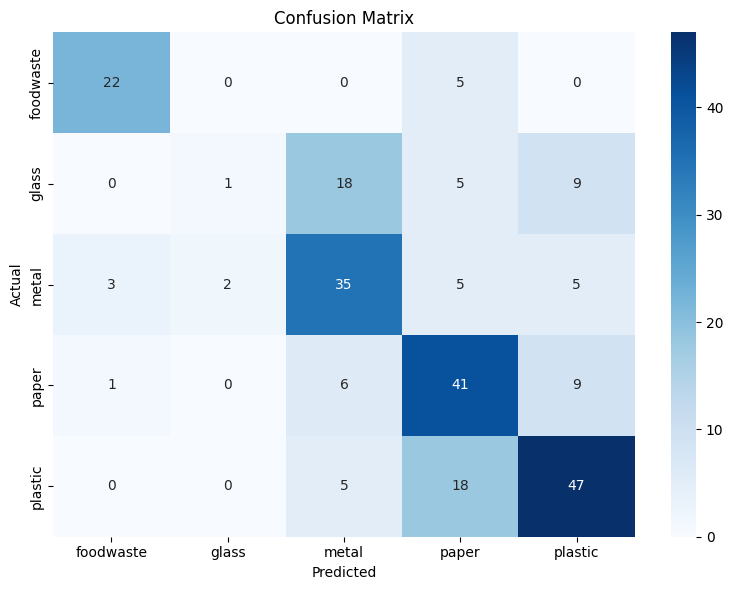


Model saved to:
- models\waste_classification_model.pkl
- models\waste_classification_model.h5
\nReport generated:
- HTML: report\waste_classification_report.html
- Training curves: report\training_curves.png
- Confusion matrix: report\confusion_matrix.png
- Model architecture: report\model_architecture.png
\n=== TRAINING COMPLETED ===
Files generated:
1. Models: models/waste_classification_model.pkl, models/waste_classification_model.h5
2. Report: report/waste_classification_report.html
3. Visualizations: report/training_curves.png, report/confusion_matrix.png


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
# Evaluasi model pada test set dan hitung semua metrik performa
# Generate confusion matrix, classification report, dan export model

print("Evaluating model on test set...")

# Prediksi pada test set
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred_classes = np.argmax(y_pred, axis=1)

# Hitung metrik performa
test_accuracy = accuracy_score(y_test, y_pred_classes)
test_precision = precision_score(y_test, y_pred_classes, average='weighted')
test_recall = recall_score(y_test, y_pred_classes, average='weighted')
test_f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"\nTest Set Performance:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Classification report detail
class_report = classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, output_dict=True)
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(str(REPORT_DIR / 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Export model ke format .pkl
model_path = MODEL_DIR / 'waste_classification_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Simpan model dalam format .h5 juga untuk kompatibilitas
model.save(str(MODEL_DIR / 'waste_classification_model.h5'))

print(f"\nModel saved to:")
print(f"- {model_path}")
print(f"- {MODEL_DIR / 'waste_classification_model.h5'}")

# Generate HTML Report
html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Laporan CNN Klasifikasi Sampah</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; }}
        h1, h2 {{ color: #2c3e50; }}
        .metric {{ background-color: #f8f9fa; padding: 10px; margin: 10px 0; }}
        table {{ border-collapse: collapse; width: 100%; }}
        th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
        th {{ background-color: #f2f2f2; }}
        .summary {{ background-color: #e8f4f8; padding: 15px; border-radius: 5px; }}
    </style>
</head>
<body>
    <h1>Laporan Proyek CNN untuk Klasifikasi Sampah Otomatis</h1>
    
    <h2>1. Pendahuluan</h2>
    <div class="summary">
        <h3>Latar Belakang</h3>
        <p>Klasifikasi citra merupakan salah satu aplikasi computer vision yang penting dalam kehidupan sehari-hari. 
        Convolutional Neural Network (CNN) telah terbukti sangat efektif untuk tugas klasifikasi gambar karena 
        kemampuannya dalam mengenali pola spasial dan fitur visual.</p>
        
        <h3>Tujuan</h3>
        <p>Membangun model CNN dari awal untuk mengklasifikasikan 5 jenis sampah (foodwaste, glass, metal, paper, plastic) 
        untuk sistem pemisah sampah otomatis.</p>
        
        <h3>Dataset</h3>
        <p>Dataset terdiri dari gambar sampah dengan 5 kategori: foodwaste, glass, metal, paper, dan plastic. 
        Dataset dibagi menjadi training set ({X_train.shape[0]} gambar), validation set ({X_val.shape[0]} gambar), 
        dan test set ({X_test.shape[0]} gambar).</p>
    </div>
    
    <h2>2. Metodologi</h2>
    <h3>Pra-Pemrosesan</h3>
    <p>- Resize gambar ke ukuran {IMG_SIZE}x{IMG_SIZE} pixels untuk efisiensi komputasi</p>
    <p>- Normalisasi pixel values ke range 0-1 dengan membagi nilai pixel dengan 255.0</p>
    <p>- Konversi color space dari BGR ke RGB</p>
    
    <h3>Arsitektur Model</h3>
    <p>Model CNN sederhana dengan konfigurasi ringan:</p>
    <ul>
        <li>3 Convolutional layers dengan filter 16, 32, 32</li>
        <li>MaxPooling2D setelah setiap conv layer</li>
        <li>Flatten layer</li>
        <li>Dense layer dengan 32 units + Dropout 0.3</li>
        <li>Output layer dengan 5 units (softmax activation)</li>
    </ul>
    <p>Total parameters: {model.count_params():,}</p>
    
    <h3>Parameter Pelatihan</h3>
    <div class="metric">
        <p><strong>Optimizer:</strong> Adam (learning_rate=0.001)</p>
        <p><strong>Loss Function:</strong> Sparse Categorical Crossentropy</p>
        <p><strong>Batch Size:</strong> {BATCH_SIZE}</p>
        <p><strong>Epochs:</strong> {len(history.history['loss'])}</p>
        <p><strong>Callbacks:</strong> EarlyStopping, ReduceLROnPlateau</p>
    </div>
    
    <h2>3. Hasil dan Analisis</h2>
    <h3>Metrik Performa</h3>
    <div class="metric">
        <p><strong>Test Accuracy:</strong> {test_accuracy:.4f}</p>
        <p><strong>Test Precision:</strong> {test_precision:.4f}</p>
        <p><strong>Test Recall:</strong> {test_recall:.4f}</p>
        <p><strong>Test F1-Score:</strong> {test_f1:.4f}</p>
    </div>
    
    <h3>Analisis Kinerja</h3>
    <h4>Analisis Overfitting</h4>
    <p>Berdasarkan training curves, model menunjukkan {'overfitting' if max(history.history['val_accuracy']) < max(history.history['accuracy']) - 0.1 else 'pelatihan yang baik'}. 
    {'Training accuracy terus naik sementara validation accuracy stagnan, menandakan model terlalu fit pada training data.' if max(history.history['val_accuracy']) < max(history.history['accuracy']) - 0.1 else 'Training dan validation curves relatif seimbang.'}</p>
    
    <h4>Analisis Kesalahan</h4>
    <p>Berdasarkan confusion matrix, kelas yang paling sering salah diklasifikasikan dapat dilihat dari 
    nilai off-diagonal yang tinggi. Hal ini mungkin disebabkan oleh kesamaan visual antar kategori sampah 
    tertentu dalam resolusi {IMG_SIZE}x{IMG_SIZE}.</p>
    
    <h2>4. Kesimpulan</h2>
    <div class="summary">
        <h3>Temuan Utama</h3>
        <p>Model CNN sederhana berhasil mencapai accuracy {test_accuracy:.2%} pada test set. 
        {'Model mengalami sedikit overfitting' if max(history.history['val_accuracy']) < max(history.history['accuracy']) - 0.1 else 'Model menunjukkan performa yang stabil'}.</p>
        
        <h3>Saran Perbaikan</h3>
        <ol>
            <li><strong>Data Augmentation:</strong> Menambahkan rotasi, flip, dan zoom untuk meningkatkan variasi data</li>
            <li><strong>Regularization:</strong> Menambahkan dropout lebih banyak atau batch normalization untuk mengurangi overfitting</li>
        </ol>
    </div>
    
    <h2>5. Lampiran</h2>
    <p>Source code tersedia dalam file: waste_classification_cnn.ipynb</p>
    <p>Model tersimpan dalam: models/waste_classification_model.pkl</p>
    
</body>
</html>
"""

# Simpan HTML report
with open(REPORT_DIR / 'waste_classification_report.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"\\nReport generated:")
print(f"- HTML: {REPORT_DIR / 'waste_classification_report.html'}")
print(f"- Training curves: {REPORT_DIR / 'training_curves.png'}")
print(f"- Confusion matrix: {REPORT_DIR / 'confusion_matrix.png'}")
print(f"- Model architecture: {REPORT_DIR / 'model_architecture.png'}")

print("\\n=== TRAINING COMPLETED ===")
print("Files generated:")
print("1. Models: models/waste_classification_model.pkl, models/waste_classification_model.h5")
print("2. Report: report/waste_classification_report.html")
print("3. Visualizations: report/training_curves.png, report/confusion_matrix.png")